In [26]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
import math
from scipy import interpolate
from scipy.signal import savgol_filter
import csv
import os
from datetime import datetime
import sys

sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *

In [17]:
_parent_folder = "omni_9dof_feb_28_2023"
_folder_name = "sk27_00_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu_df.csv"))
_sk_df["time"] = _sk_df["time"].apply(lambda x: datetime.fromtimestamp(x))



In [18]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [30]:
def validation(df):
    # columns =['gyrox1','gyroy1','gyroz1','accelx1','accely1','accelz1','Time']
    # df = pd.read_csv(imu_file, usecols=columns)

    _acceleration_filter_window = 101
    _acceleration_filter_order = 9
    _gyro_filter_window = 81
    _gyro_filter_order = 9

    df.ax = savgol_filter(df.ax, _acceleration_filter_window, _acceleration_filter_order)
    df.ay = savgol_filter(df.ay, _acceleration_filter_window, _acceleration_filter_order)
    df.az = savgol_filter(df.az, _acceleration_filter_window, _acceleration_filter_order)
    df.gx = savgol_filter(df.gx, _gyro_filter_window, _gyro_filter_order)
    df.gy = savgol_filter(df.gy, _gyro_filter_window, _gyro_filter_order)
    df.gz = savgol_filter(df.gz, _gyro_filter_window, _gyro_filter_order)

    _gx_offset = df.gx[:100].mean()
    _gy_offset = df.gy[:100].mean()
    _gz_offset = df.gz[:100].mean()


    q4=[]
    Q1=[]
    accx1=df.ax
    accy1=df.ay
    accz1=df.az
    angx=np.deg2rad(df.gx- _gx_offset) 
    angy=np.deg2rad(df.gy- _gy_offset) 
    angz=np.deg2rad(df.gz- _gz_offset) 

    ang_comp=[]
    a=0.005
    for j in range(len(angx)):
        norm=np.linalg.norm([angx[j],angy[j],angz[j]]) 
        axis_of_rot=[angx[j]/norm,angy[j]/norm,angz[j]/norm]
        theta= 0.01*norm
        q0=math.cos(theta/2)
        q1=(axis_of_rot[0])*math.sin(theta/2)
        q2=(axis_of_rot[1])*math.sin(theta/2)
        q3=(axis_of_rot[2])*math.sin(theta/2)
        q_comp=[q0,q1,q2,q3]
        Q=[0,accx1[j],accy1[j],accz1[j]]
        Q1.append(Q)
        q4.append(q_comp)
    s_comp=q4[0]
    for j in range(len(q4)):
        dummy=s_comp
        normq5=((dummy[0]*dummy[0])+(dummy[1]*dummy[1])+(dummy[2]*dummy[2])+(dummy[3]*dummy[3]))
        invq51=[s_comp[0]/normq5,s_comp[1]/normq5,s_comp[2]/normq5,s_comp[3]/normq5]
        invq5=[invq51[0],-1*invq51[1],-1*invq51[2],-1*invq51[3]]
        qupdat1=quaternion_multiply(s_comp,Q1[j])
        qupdate=quaternion_multiply(qupdat1,invq5)
        norm1=np.sqrt((qupdate[0]*qupdate[0])+(qupdate[1]*qupdate[1])+(qupdate[2]*qupdate[2])+(qupdate[3]*qupdate[3]))
        init=Q1[0][1:]
        new_qup=[qupdate[0]/norm1,qupdate[1]/norm1,qupdate[2]/norm1,qupdate[3]/norm1]
        rot_ax=np.cross(new_qup[1:],init)
        norm=np.linalg.norm(rot_ax)
        axis_of_rot=rot_ax/norm
        thet=(np.dot(new_qup[1:],init))/((np.linalg.norm(new_qup[1:])*np.linalg.norm(init)))
        theta=np.arccos(thet)
        q0=math.cos(a*theta/2)
        q1=(axis_of_rot[0])*math.sin(a*theta/2)
        q2=(axis_of_rot[1])*math.sin(a*theta/2)
        q3=(axis_of_rot[2])*math.sin(a*theta/2)
        qt=[q0,q1,q2,q3]
        s=quaternion_multiply(s_comp,q4[j])
        s_comp=quaternion_multiply(qt,s)
        finaltheta=np.rad2deg(2*np.arccos(s_comp[0]))
        ang_comp.append(finaltheta)
    
    IMU=ang_comp
    return IMU

In [31]:
_imu =  validation(_sk_df)

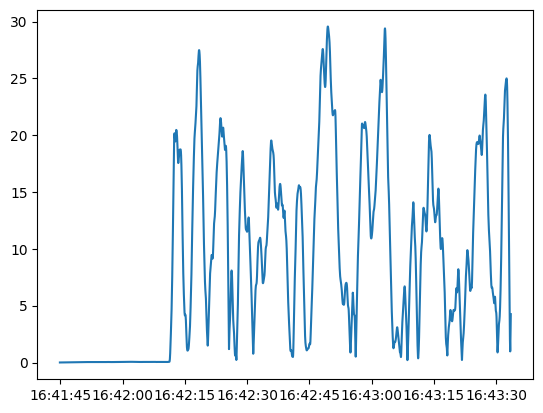

In [33]:
plt.plot(_sk_df.time[:10000], _imu[:10000])

In [27]:
# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(1)
_om = get_marker_name(3)

# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

,frame,seconds,rb_ang_x,rb_ang_y,rb_ang_z,rb_ang_w,rb_pos_x,rb_pos_y,rb_pos_z,rb_pos_err,...,m2_x,m2_y,m2_z,m3_x,m3_y,m3_z,m4_x,m4_y,m4_z,time
0,0,0.00,-0.001507,-0.000727,0.002973,-0.999994,0.039218,0.049546,0.051924,0.000043,...,0.003602,0.050147,0.041298,0.051863,0.049464,0.046483,0.055384,0.049272,0.006330,2023-02-28 16:41:55.054
1,1,0.01,-0.001544,-0.000742,0.003380,-0.999993,0.039217,0.049546,0.051926,0.000046,...,0.003605,0.050177,0.041304,0.051864,0.049454,0.046487,0.055379,0.049262,0.006324,2023-02-28 16:41:55.064
2,2,0.02,-0.001658,-0.000743,0.003239,-0.999993,0.039214,0.049542,0.051923,0.000039,...,0.003591,0.050165,0.041296,0.051851,0.049426,0.046472,0.055387,0.049291,0.006333,2023-02-28 16:41:55.074
3,3,0.03,-0.000246,-0.000477,0.003017,-0.999995,0.039200,0.049592,0.051980,0.000130,...,0.003602,0.050169,0.041298,0.051858,0.049419,0.046472,0.055369,0.049249,0.006325,2023-02-28 16:41:55.084
4,4,0.04,-0.001543,-0.000796,0.003336,-0.999993,0.039208,0.049542,0.051928,0.000049,...,0.003595,0.050170,0.041304,0.051845,0.049434,0.046466,0.055367,0.049271,0.006344,2023-02-28 16:41:55.094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61954,61954,619.54,-0.001234,-0.048931,0.005543,-0.998786,-0.138833,0.050815,0.004589,0.000149,...,-0.175333,0.051595,-0.002653,-0.126825,0.050600,-0.002128,-0.127126,0.050503,-0.042329,2023-02-28 16:52:14.594
61955,61955,619.55,-0.001354,-0.048903,0.005293,-0.998789,-0.138833,0.050804,0.004592,0.000143,...,-0.175321,0.051569,-0.002648,-0.126834,0.050582,-0.002125,-0.127122,0.050520,-0.042312,2023-02-28 16:52:14.604
61956,61956,619.56,-0.001591,-0.048849,0.005258,-0.998791,-0.138835,0.050799,0.004595,0.000123,...,-0.175323,0.051565,-0.002653,-0.126828,0.050637,-0.002086,-0.127126,0.050502,-0.042322,2023-02-28 16:52:14.614
61957,61957,619.57,-0.001889,-0.048730,0.005550,-0.998795,-0.138844,0.050781,0.004599,0.000162,...,-0.175325,0.051574,-0.002658,-0.126830,0.050593,-0.002127,-0.127130,0.050519,-0.042314,2023-02-28 16:52:14.624
